In [473]:
import numpy as np
import matplotlib.pyplot as plt
import theano
import theano.tensor as T
%matplotlib inline

In [474]:
import lasagne
from lasagne.layers import *

In [475]:
input_X=T.tensor3("X")
output_Y=T.vector("Y",dtype="float32")

In [476]:
N=150
input_shape=[100,N,2]


In [547]:
gl1=InputLayer(shape=[100,N,20],input_var=input_X)
gl2=DenseLayer(gl1,num_units=N*5,nonlinearity=lasagne.nonlinearities.elu)
gl3=DenseLayer(gl2,num_units=N*3,nonlinearity=lasagne.nonlinearities.tanh)
gl_out=DenseLayer(gl3,num_units=N*2,nonlinearity=lasagne.nonlinearities.linear)

y_g_pred=lasagne.layers.get_output(gl_out)

weights_g=lasagne.layers.get_all_params(gl_out)


In [549]:
dl1T=InputLayer(shape=input_shape,input_var=input_X)
dl2T=DenseLayer(dl1T,num_units=N,nonlinearity=lasagne.nonlinearities.elu)
dl3T=DenseLayer(dl2T,num_units=10,nonlinearity=lasagne.nonlinearities.sigmoid)
dlT_out=DenseLayer(dl3T,num_units=2,nonlinearity=lasagne.nonlinearities.softmax)

y_dT_pred=lasagne.layers.get_output(dlT_out)

weights_d=lasagne.layers.get_all_params(dlT_out)
dlg_input=y_g_pred.reshape(shape=input_shape)
dl1G=InputLayer(shape=input_shape,input_var=dlg_input)
dl2G=DenseLayer(dl1G,num_units=N,nonlinearity=lasagne.nonlinearities.elu,W=dl2T.W,b=dl2T.b)
dl3G=DenseLayer(dl2G,num_units=10,nonlinearity=lasagne.nonlinearities.sigmoid,W=dl3T.W,b=dl3T.b)
dlG_out=DenseLayer(dl3G,num_units=2,nonlinearity=lasagne.nonlinearities.softmax,W=dlT_out.W,b=dlT_out.b)

y_dG_pred=lasagne.layers.get_output(dlG_out)

loss_dT=-T.mean([(T.log(y_dT_pred[i][0]+1e-9))*(1-output_Y[i])+T.log(1e-9+y_dT_pred[i][1])*output_Y[i] for i in range(100)])
loss_dG=-T.mean([T.log(y_dG_pred[i][0]+1e-9) for i in range(100)])
accuracy_dT=lasagne.objectives.categorical_accuracy(y_dT_pred,output_Y).mean()
accuracy_dG=lasagne.objectives.categorical_accuracy(y_dG_pred,output_Y).mean()
updates_sgd_dT=lasagne.updates.adadelta(loss_dT,weights_d,learning_rate=0.3)
updates_sgd_dG=lasagne.updates.adadelta(loss_dG,weights_d,learning_rate=0.3)

train_fun_dT=theano.function([input_X,output_Y],[loss_dT,accuracy_dT],updates=updates_sgd_dT)
train_fun_dG=theano.function([input_X,output_Y],[loss_dG,accuracy_dG],updates=updates_sgd_dG)

accuracy_fun_dT=theano.function([input_X,output_Y],accuracy_dT)
accuracy_fun_dG=theano.function([input_X,output_Y],accuracy_dG)

loss_g=-T.mean([T.log(y_dG_pred[i][1]+1e-9) for i in range(100)])
accuracy_g=lasagne.objectives.categorical_accuracy(y_dG_pred,1-output_Y).mean()
updates_sgd_g=lasagne.updates.adadelta(loss_g,weights_g,learning_rate=0.3)

train_fun_g=theano.function([input_X,output_Y],[loss_g,accuracy_g],updates=updates_sgd_g)
accuracy_fun_g=theano.function([input_X,output_Y],accuracy_g)

In [550]:
def make_normal(center,mu,sz):
    return np.random.normal(center,mu,size=sz)

In [555]:
def make_noise(sz):
    return np.random.random(size=sz)

In [556]:
def make_input_output(center,mu,sz,batch_sz):
    inpt=[]
    outpt=[]
    for i in range(batch_sz):
        x=np.random.random()
        if x<0.2:
            inpt.append(make_noise(sz))
            outpt.append(0)
        elif x<0.4:
            ran=np.random.random()
            inpt.append(make_normal(0,ran,sz))
            outpt.append(0)
        elif x<0.7:
            inpt.append(make_normal(center,mu,sz))
            outpt.append(1)
        elif x<0.9:
            inpt.append(make_normal(center-10,mu,sz))
            outpt.append(0)
        else:
            inpt.append(make_normal(center+10,mu,sz))
            outpt.append(0)
    return inpt,outpt

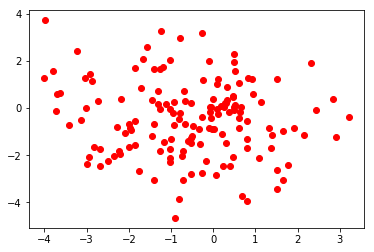

In [575]:
p=y_g_pred.eval({input_X:make_noise([100,N,20])}).reshape(input_shape)
plt.plot([i[0] for i in p[0]],[i[1] for i in p[0]],'ro')

In [558]:
center=5
mu=1

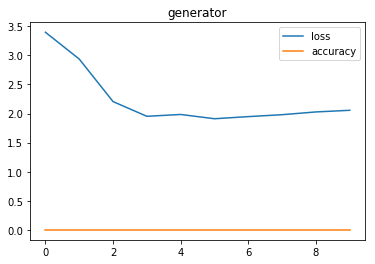

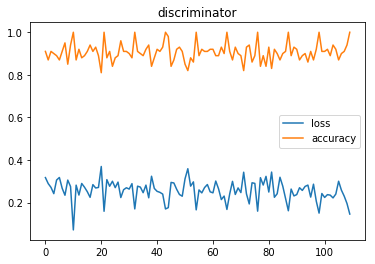

In [574]:
num_ep=100
losses=[]
accuracies=[]
losses1=[]
accuracies1=[]
for i in range(num_ep):
    inpt,outpt=make_input_output(center,mu,input_shape[1:],100)
    loss1,accuracy1=train_fun_dT(inpt,outpt)
    losses1.append(loss1)
    accuracies1.append(accuracy1)
    if i%10==9:
        input_noise=make_noise(sz=[100,N,20])
        loss,accuracy=train_fun_g(input_noise,[0]*100)
        loss1,accuracy1=train_fun_dG(input_noise,[0]*100)
        losses.append(loss)
        accuracies.append(accuracy)
        losses1.append(loss1)
        accuracies1.append(accuracy1)
plt.title('generator')
plt.plot(losses,label="loss")
plt.plot(accuracies,label='accuracy')
plt.legend()
plt.show()
plt.title('discriminator')
plt.plot(losses1,label="loss")
plt.plot(accuracies1,label='accuracy')
plt.legend()
plt.show()

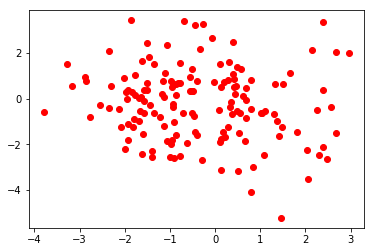

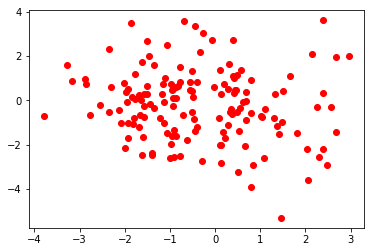

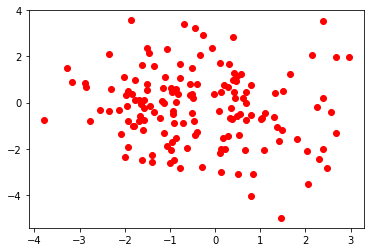

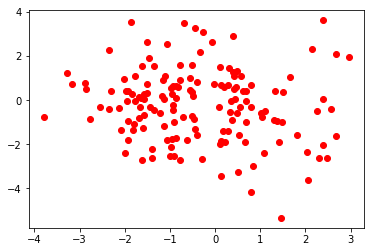

In [570]:
p=y_g_pred.eval({input_X:make_noise([100,N,20])}).reshape([100,N,2])
plt.plot([i[0] for i in p[0]],[i[1] for i in p[0]],'ro')
plt.show()
plt.plot([i[0] for i in p[0]],[i[1] for i in p[1]],'ro')
plt.show()
plt.plot([i[0] for i in p[0]],[i[1] for i in p[2]],'ro')
plt.show()
plt.plot([i[0] for i in p[0]],[i[1] for i in p[3]],'ro')
plt.show()

In [571]:
print(y_dT_pred.eval({input_X:make_noise(sz=[100,N,2])})[0])
print(y_dT_pred.eval({input_X:make_normal(5,1,sz=[100,N,2])})[0])
print(y_dG_pred.eval({input_X:make_noise(sz=[100,N,20])})[0])
print(accuracy_fun_dT(make_normal(5,1,sz=[100,N,2]),[1]*100))
print(accuracy_fun_dT(make_normal(15,1,sz=[100,N,2]),[0]*100))
print(accuracy_fun_dT(make_noise(sz=[100,N,2]),[0]*100))
print(accuracy_fun_dG(make_noise(sz=[100,N,20]),[0]*100))


[ 0.95208486  0.04791514]
[ 0.37068449  0.62931551]
[ 0.96440609  0.03559391]
1.0
0.0
1.0
1.0


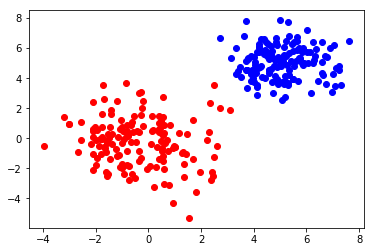

In [572]:
p=y_g_pred.eval({input_X:make_noise([100,N,20])}).reshape([100,N,2])
p1=make_normal(5,1,[1,N,2])
plt.plot([i[0] for i in p[0]],[i[1] for i in p[0]],'ro')
plt.plot([i[0] for i in p1[0]],[i[1] for i in p1[0]],'bo')

In [573]:
y_dT_pred.eval({input_X:p})

array([[ 0.96495038,  0.03504962],
       [ 0.96442375,  0.03557625],
       [ 0.9650524 ,  0.0349476 ],
       [ 0.96475178,  0.03524822],
       [ 0.9648497 ,  0.0351503 ],
       [ 0.96471749,  0.03528251],
       [ 0.96523128,  0.03476872],
       [ 0.96473559,  0.03526441],
       [ 0.96468408,  0.03531592],
       [ 0.96479161,  0.03520839],
       [ 0.96506706,  0.03493294],
       [ 0.96468693,  0.03531307],
       [ 0.96539653,  0.03460347],
       [ 0.96498696,  0.03501304],
       [ 0.96511842,  0.03488158],
       [ 0.96487346,  0.03512654],
       [ 0.96483057,  0.03516943],
       [ 0.9651445 ,  0.0348555 ],
       [ 0.96518356,  0.03481644],
       [ 0.96490089,  0.03509911],
       [ 0.96508567,  0.03491433],
       [ 0.96505042,  0.03494958],
       [ 0.96504885,  0.03495115],
       [ 0.96474422,  0.03525578],
       [ 0.9647655 ,  0.0352345 ],
       [ 0.96493864,  0.03506136],
       [ 0.9650389 ,  0.0349611 ],
       [ 0.96511639,  0.03488361],
       [ 0.96509239,